In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib qt

In [3]:
# Camera calibration

# get the path to the calibration images
images = glob.glob('camera_cal/*.jpg')

In [4]:
# decide chessboard dimensions
nx = 9
ny = 6

In [4]:
# loop through all the images to get image points (the coordinates of the corners)

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)


for image in images:
    
    img = cv2.imread(image)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


Text(0.5, 1.0, 'Undistorted Image')

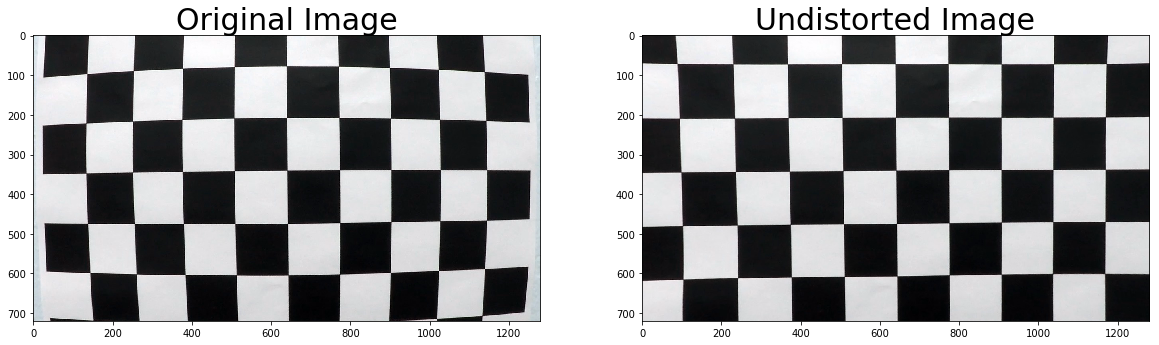

In [5]:

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',undist)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
#plt.imsave("output_images/undistort.jpg", undist)

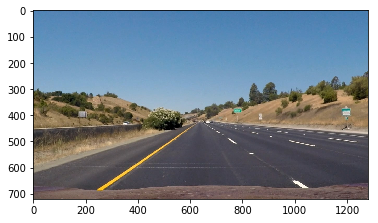

In [6]:
# read in an image to perform the test on setting threshold
image = cv2.imread('test_images/straight_lines1.jpg')
#image = cv2.imread('captures/frame631.jpg')
#image = cv2.imread('test_images/test4.jpg')
image_copy = image.copy()

# show the original image
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR)
plt.imshow(image_copy)

In [ ]:
image.shape

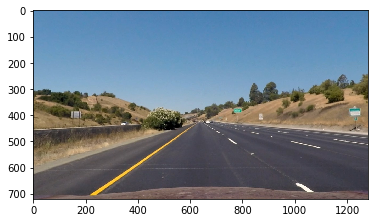

In [8]:
# undistort the image
undist_image = cv2.undistort(image_copy, mtx, dist, None, mtx)
#undist_image = cv2.cvtColor(undist_image, cv2.COLOR_RGB2BGR)
plt.imshow(undist_image)
#plt.imsave("output_images/undistorted_test5.jpg", undist_image)

In [9]:
gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)

In [ ]:
'''
image_LAB = cv2.cvtColor(undist_image, cv2.COLOR_RGB2LAB)
L_channel = image_LAB[:,:,0]
A_channel = image_LAB[:,:,1]
B_channel = image_LAB[:,:,2]
f, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(20,10))
axis1.imshow(L_channel)
axis1.set_title('L Channel', fontsize=20)
axis2.imshow(A_channel)
axis2.set_title('A Channel', fontsize=20)
axis3.imshow(B_channel)
axis3.set_title('B Channel', fontsize=20)
'''

Text(0.5, 1.0, 'V Channel')

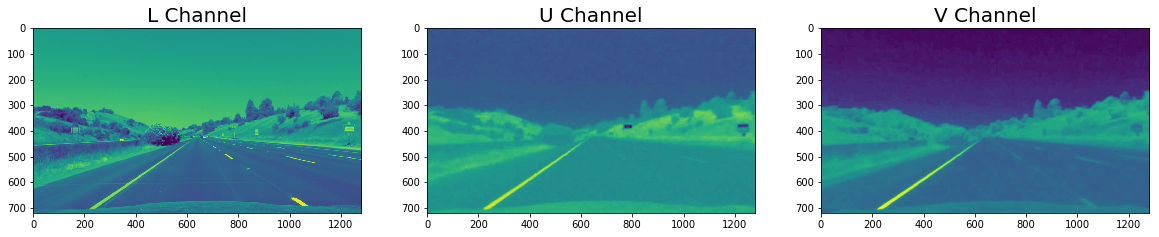

In [10]:
# convert image to HLS color space to check which one shows the lanes best
image_LUV = cv2.cvtColor(undist_image, cv2.COLOR_RGB2Luv)
L_channel = image_LUV[:,:,0]
U_channel = image_LUV[:,:,1]
V_channel = image_LUV[:,:,2]
f, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(20,10))
axis1.imshow(L_channel)
axis1.set_title('L Channel', fontsize=20)
axis2.imshow(U_channel)
axis2.set_title('U Channel', fontsize=20)
axis3.imshow(V_channel)
axis3.set_title('V Channel', fontsize=20)
# obviously, the L Channel picks up the yellow lane the best
# and the V channel picks up the white lane the best

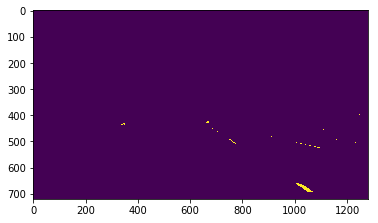

In [11]:
# for the yellow lane
thresh = (225, 255)
l_binary = np.zeros_like(L_channel)
l_binary[(L_channel > thresh[0]) & (L_channel <= thresh[1])] = 1
plt.imshow(l_binary)


In [ ]:
'''
thresh = (150, 200)
b_binary = np.zeros_like(B_channel)
b_binary[(B_channel > thresh[0]) & (B_channel <= thresh[1])] = 1
plt.imshow(b_binary)
'''

In [ ]:
# convert image to HLS color space to check which one shows the lanes best
'''
hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
H_channel = hls[:,:,0]
L_channel = hls[:,:,1]
S_channel = hls[:,:,2]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(H_channel)
ax1.set_title('H Channel', fontsize=20)
ax2.imshow(L_channel)
ax2.set_title('L Channel', fontsize=20)
ax3.imshow(S_channel)
ax3.set_title('S Channel', fontsize=20)
'''
# obviously, the S Channel picks up the lanes best

In [ ]:
'''
thresh = (90, 255)
s_binary = np.zeros_like(S_channel)
s_binary[(S_channel > thresh[0]) & (S_channel <= thresh[1])] = 1
plt.imshow(s_binary)
'''

In [ ]:
# this pipeline processed the image by applying sobelx and choosing HLS's S channel to highlight the lanes, 
# the pipeline will produce a binary image
#s_thresh=(170, 255), sx_thresh=(100, 200)
'''
def binary_pipeline(image, s_thresh=(170, 255), sx_thresh=(0, 255)):
    image = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # apply Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary
    '''

In [12]:
# this pipeline processed the image by applying sobelx and choosing LUV's L channel to highlight the lanes, 
# the pipeline will produce a binary image
def binary_pipeline(image, l_thresh=(225, 255), v_thresh=(200,255)):
    image_copy = np.copy(image)
    # Convert to LUV color space and separate the l channel and v channel
    image_LUV = cv2.cvtColor(image_copy, cv2.COLOR_RGB2Luv)
    l_channel = image_LUV[:,:,0]
    v_channel = image_LUV[:,:,2]
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( np.zeros_like(l_binary), l_binary, v_binary)) * 255
    
    return color_binary


In [1]:
edited_image = binary_pipeline(undist_image, l_thresh=(225, 255), v_thresh=(200,255))
#edited_image = binary_pipeline(undist_image, s_thresh=(170, 255), sx_thresh=(50, 200))
plt.imshow(edited_image)
plt.imsave("output_images/binary_image.jpg", edited_image)

NameError: name 'binary_pipeline' is not defined

In [18]:
# estimated begining point height, and ending point height
beg_point = 460
end_point = 720

In [19]:
# draw the source points
# functions borrowed from project 1
# region of interest
# draw
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    
    # calculate each line's slope
    slopes = []
    i = 0
    for line in lines:
        slopes.append((line[0][3] - line[0][1]) / (line[0][2] - line[0][0]))
        i += 1
    
    # group lines by +ve and -ve slopes, +ve is left, -ve is right
    left_lines = []
    right_lines = []
    left_slope_sum = 0
    right_slope_sum = 0
    
    j = 0
    for slope in slopes:
        if slope > 0:
            left_lines.append(lines[j])
            left_slope_sum += slope
        else:
            right_lines.append(lines[j])
            right_slope_sum += slope
        j += 1
    
    # averaging the slopes
    left_slope_avg = left_slope_sum/len(left_lines)
    right_slope_avg = right_slope_sum/len(right_lines)
    # get a random pt
    
    left_point_index = np.random.randint(len(left_lines))
    left_line = left_lines[left_point_index]
    left_point = [left_line[0][0], left_line[0][1]]
    
    if left_slope_avg < 50 and left_slope_avg > -50:
        upper_left_x = int((beg_point - left_point[1] + left_slope_avg * left_point[0]) / left_slope_avg)
        lower_left_x = int((end_point - left_point[1] + left_slope_avg * left_point[0]) / left_slope_avg)
        img = cv2.line(img, (upper_left_x, beg_point), (lower_left_x, end_point), color, thickness)
        
    right_point_index = np.random.randint(len(right_lines))
    right_line = right_lines[right_point_index]
    right_point = [right_line[0][0], right_line[0][1]]
    
    if right_slope_avg < 50 and right_slope_avg > -50:
        upper_right_x = int((beg_point - right_point[1] + right_slope_avg * right_point[0]) / right_slope_avg )
        lower_right_x = int((end_point - right_point[1] + right_slope_avg * right_point[0]) / right_slope_avg )
        img = cv2.line(img, (upper_right_x, beg_point), (lower_right_x, end_point), color, thickness)
        
    return right_slope_avg, left_slope_avg, right_point, left_point
    
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    right_slope, left_slope, right_point, left_point = draw_lines(line_img, lines)
    
    return line_img, right_slope, left_slope, right_point, left_point

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

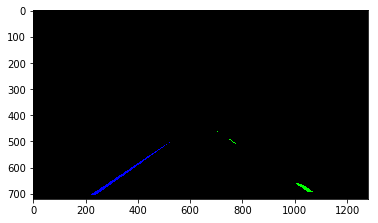

In [20]:
imshape = edited_image.shape
vertices = np.array([[(0,imshape[0]),(570, 460), (800, 460), (imshape[1],imshape[0])]], dtype=np.int32)

# mark the region of interest (the lanes area)
masked_edges = region_of_interest(edited_image, vertices)
plt.imshow(masked_edges)

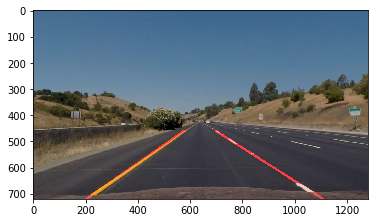

In [21]:
# run Hough transformation and draw the lanes in red
masked = cv2.cvtColor(masked_edges, cv2.COLOR_BGR2GRAY)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100 #minimum number of pixels making up a line
max_line_gap = 160   # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
line_image, right_slope, left_slope, right_point, left_point = hough_lines(masked, rho, theta, threshold, min_line_length, max_line_gap)

# Draw the lines on the edge image
lines_edges = weighted_img(line_image, undist_image)
plt.imshow(lines_edges)
plt.imsave("output_images/after_hough.jpg", lines_edges)

In [22]:
# get source points and dest points 
# calculating source points coordinate
print(left_point)
print(right_point)
print(left_slope)
print(right_slope)
# source point 1
y1 = beg_point
x1 = int((y1 - left_point[1] + left_slope * left_point[0]) / left_slope)
#print(x1)
# source point 2
y2 = beg_point
x2 = int((y2 - right_point[1] + right_slope * right_point[0]) / right_slope)
#print(x2)
# source point 3
y3 = end_point
x3 = int((y3 - left_point[1] + left_slope * left_point[0]) / left_slope)
#print(x3)
# source point 4
y4 = end_point
x4 = int((y4 - right_point[1] + right_slope * right_point[0]) / right_slope)
#print(x4)
src_points = [[x2, y2], [x1, y1], [x3, y3], [x4, y4]]
src_points = np.asarray(src_points, dtype='float32')
print(src_points)

[702, 462]
[226, 704]
0.6327987785378891
-0.696855756182562
[[ 576.  460.]
 [ 698.  460.]
 [1109.  720.]
 [ 203.  720.]]


In [23]:
# destination points, it should be a rectangle

dest_points = []
dest_points.append([280, 0])
dest_points.append([1000, 0])

dest_points.append([1000, 720])
dest_points.append([280, 720])
dest_points = np.asarray(dest_points, dtype='float32')


In [24]:
# apply a "bird-eye-view" perspective transform

M = cv2.getPerspectiveTransform(src_points, dest_points)

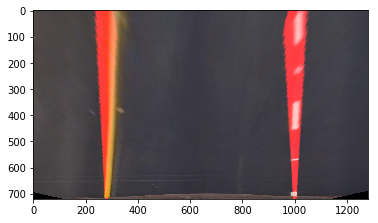

In [25]:

img_size = gray.shape[::-1]
warped_img = cv2.warpPerspective(lines_edges, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped_img)
plt.imsave("output_images/warped_imaged.jpg", warped_img)

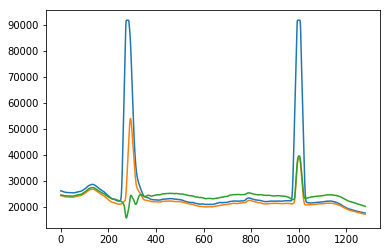

In [26]:
# Detect lane pixels and fit to find the lane boundary.

# Plot histogram

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram



# Create histogram of image binary activations
histogram = hist(warped_img)

# Visualize the resulting histogram
plt.plot(histogram)

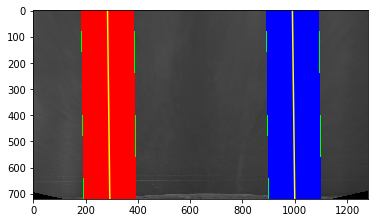

In [27]:
# this function will draw 2 histograms represent the lane lines, 
# draw sliding windows to cover the lanes and identify nonzero pixels
# the following fit_polynomial function will fit a second order polynomial to fit the lane pixels

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    if len(leftx) > 0 and len(lefty) > 0 and len(rightx) > 0 and len(righty) > 0:
        
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
    else:
        return None, None, None, None, None, None
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

gray_scale = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(gray_scale)

plt.imshow(out_img)

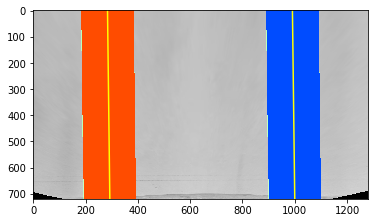

In [28]:
# this cell's functions are used to search the lane pixels around a margin,
# using previous frame's poly fit

# Polynomial fit values from the previous frame

def fit_poly(img_shape, leftx, lefty, rightx, righty, left_fit, right_fit):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # if lef
    if len(leftx) > 0 and len(lefty) > 0 and len(rightx) > 0 and len(righty) > 0:
    #if len(leftx) > 0 or len(rightx) > 0:
    # Fit new polynomials
        left_fitx, right_fitx, left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, left_fit, right_fit)
    else:
        return None, None, None, None
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    # Fit new polynomials to x,y in world space
    
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty


result, left_fitx, right_fitx, ploty = search_around_poly(gray_scale, left_fit, right_fit)

# View output
plt.imshow(result)

In [29]:
# Determine the curvature of the lane in pixels
# calculate the radius of the curvature of the fit

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)

1.6462269029788124e+16 4996677862699906.0


In [30]:
# Measure the real curvature, in meters

def measure_curvature_real(left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 23/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # move to center
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, left_fit_cr, right_fit_cr


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, left_fit_cr, right_fit_cr = measure_curvature_real(left_fitx, right_fitx)

print(left_curverad, 'm', right_curverad, 'm')

2638315250066798.0 m 1062011889159442.2 m


In [31]:
# vehicle position with respect to center

def measure_vehicle_position(left_fitx, right_fitx):
    
    midpoint_lane = (right_fitx[719] + left_fitx[719]) / 2
    midpoint_image = 1280/2
    xm_per_pix = 3.7/700
    offset_pixels = midpoint_lane - midpoint_image
    offset = offset_pixels * xm_per_pix
    
    return offset

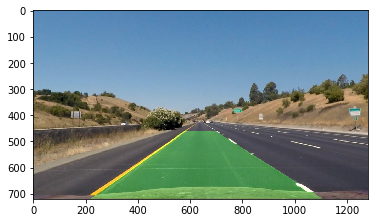

In [32]:
# change perspective back to the road

# Create an image to draw the lines on
warp_zero = np.zeros_like(gray_scale).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = cv2.getPerspectiveTransform(dest_points, src_points)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.imsave("output_images/result.jpg", result)

In [33]:
# I made the left fit and right fit polys global
# need to run this cell for every run of video
left_fit = None
right_fit = None
ploty = None
adjusted_result = None
adjusted_offset = 0
adjusted_left_cr = None
adjusted_right_cr = None
adjusted_left_curverad = 0
adjusted_right_curverad = 0
prev_green_area = []
count_out = 0
sanity = 0

In [37]:
# This is the main pipeline that combine the procedures above to process frame one by one
# it undists an image, turn it to gray and produce a binary image to highlight the lanes
# Then, it changes the lanes area to bird-eye-view and fit a polynomial to nonzero pixels.
# It changes the image back to original perspective with green area of the lane highlighted.
# It also calculates the lane radius of curvatures and vehicle position with respect to center
# of the image.  Finally, it display the information on the image and return the image.

def process_image(image):
    
    global left_fit
    global right_fit
    global ploty
    global adjusted_result
    global adjusted_offset
    global adjusted_left_cr
    global adjusted_right_cr
    global adjusted_left_curverad
    global adjusted_right_curverad
    global prev_green_area
    global count_out
    global sanity
    
    # get basic info of the image, and make a copy
    ysize = image.shape[0]
    xsize = image.shape[1]
    image_copy = np.copy(image)
    
    # undistort image
    undist_image = cv2.undistort(image_copy, mtx, dist, None, mtx)
    # turn image to gray scale
    gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)
    # apply color analysis and sobel x, return a binary image
    binary_image = binary_pipeline(undist_image, l_thresh=(225, 255), v_thresh=(200, 255))
    #binary_image = binary_pipeline(undist_image, s_thresh=(170, 255), sx_thresh=(50, 200))
    # using the source points and destination points I've decided using one of the image
    # apply a perspective transform
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    # using the vertices I've decided to show only the region of interest
    masked_edges = region_of_interest(binary_image, vertices)
    # get the image size
    img_size = gray.shape[::-1]
    # apply warp perspective transform
    warped_img = cv2.warpPerspective(masked_edges, M, img_size, flags=cv2.INTER_LINEAR)
    # turn the warped image to grayscale
    gray_scale_warped = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
    # detect if it is the first time to detect lane
    
    out_img = None
    # draw histograms on the lanes and fit polynomials
    # save time and efforts after the first left_fit and right_fit poly were done, 
    # by searching around the polys within a margin
    if left_fit is not None and right_fit is not None:
        out_img, left_fitx, right_fitx, ploty = search_around_poly(gray_scale_warped, left_fit, right_fit) 
    # fit the lane pixels to polynomials if there is no previous fit, or if search_around_poly can't
    #  find the lanes.
    if out_img is None:
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(gray_scale_warped)
        
    accepted_newwarp = None
    #count_out = 0
    
    if not out_img is None:
        
        # measure curvature and vehical offset position
        left_curverad, right_curverad, left_fit_cr, right_fit_cr = measure_curvature_real(left_fitx, right_fitx)
        offset = measure_vehicle_position(left_fitx, right_fitx)
        # take care of the first frame
        if adjusted_left_cr is None:
            adjusted_left_cr = left_fit_cr
            adjusted_right_cr = right_fit_cr
        # sanity check for the detected left and right lanes
        # check if curvature is valid
            # check if there is line pixel detected
            # check if the lanes are too much different from the previous frame
        if not np.abs(left_curverad - right_curverad > 1000) \
            and not (left_fitx is None or right_fitx is None)\
            #and not (left_fit_cr[0] - right_fit_cr[0] > 1)\
            #and not (left_fit_cr[1] - right_fit_cr[1] > 1)\
            #and not (left_fit_cr[2] - right_fit_cr[2] > 1):
            
            # this section is used to draw the green area and change transpose the 
            # warped perspective back to the original image
    
            # Create an image to draw the lines on
            warp_zero = np.zeros_like(gray_scale_warped).astype(np.uint8)
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            Minv = cv2.getPerspectiveTransform(dest_points, src_points)
            newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
            
            prev_green_area.append(newwarp)
            accepted_newwarp = newwarp
            adjusted_offset = offset
            adjusted_left_cr = left_fit_cr
            adjusted_right_cr = right_fit_cr
            adjusted_left_curverad = left_curverad
            adjusted_right_curverad = right_curverad
        
        else:
            sanity += 1
            print("out_image not None, but doesn't pass sanity: "+str(sanity))
            # use the previous green area
            if len(prev_green_area) > 0:
                accepted_newwarp = prev_green_area[-1]
                print(len(prev_green_area))
            else:
                return undist_image
    else:
        count_out += 1
        print("count_out: "+str(count_out))
        # use the previous green area
        if len(prev_green_area) > 0:
            accepted_newwarp = prev_green_area[-1]
            print(len(prev_green_area))
        else:
            return undist_image
    
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, accepted_newwarp, 0.3, 0)
    
    # show the curvatures and vehicle position offset in the image
    cv2.putText(result, "Left Radius of Curvature: %d meters" % adjusted_left_curverad, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.putText(result, "Right Radius of Curvature: %d meters" % adjusted_right_curverad, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.putText(result, "Vehicle Position: %.2f meters offset" % adjusted_offset, (100,300), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    
    return result
    

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  2%|█▋                                                                              | 26/1261 [00:02<01:42, 12.03it/s]

out_image not None, but doesn't pass sanity: 1
27


  6%|█████                                                                           | 79/1261 [00:07<01:46, 11.06it/s]

out_image not None, but doesn't pass sanity: 2
80


  6%|█████▏                                                                          | 81/1261 [00:07<01:49, 10.78it/s]

out_image not None, but doesn't pass sanity: 3
80
out_image not None, but doesn't pass sanity: 4
80


  7%|█████▎                                                                          | 83/1261 [00:07<01:48, 10.89it/s]

out_image not None, but doesn't pass sanity: 5
80
out_image not None, but doesn't pass sanity: 6
80


  7%|█████▍                                                                          | 85/1261 [00:07<01:49, 10.79it/s]

out_image not None, but doesn't pass sanity: 7
80


 14%|███████████▎                                                                   | 181/1261 [00:16<01:41, 10.63it/s]

out_image not None, but doesn't pass sanity: 8
175
out_image not None, but doesn't pass sanity: 9
175


 15%|███████████▍                                                                   | 183/1261 [00:17<01:43, 10.44it/s]

out_image not None, but doesn't pass sanity: 10
175


 24%|██████████████████▋                                                            | 298/1261 [00:28<01:29, 10.74it/s]

out_image not None, but doesn't pass sanity: 11
290


 25%|███████████████████▌                                                           | 312/1261 [00:29<01:24, 11.21it/s]

out_image not None, but doesn't pass sanity: 12
302
out_image not None, but doesn't pass sanity: 13
302


 25%|████████████████████                                                           | 321/1261 [00:30<01:54,  8.18it/s]

out_image not None, but doesn't pass sanity: 14
309
out_image not None, but doesn't pass sanity: 15
309


 26%|████████████████████▏                                                          | 323/1261 [00:30<01:47,  8.71it/s]

out_image not None, but doesn't pass sanity: 16
309
out_image not None, but doesn't pass sanity: 17
309


 26%|████████████████████▎                                                          | 325/1261 [00:31<01:41,  9.19it/s]

out_image not None, but doesn't pass sanity: 18
309
out_image not None, but doesn't pass sanity: 19
309


 26%|████████████████████▍                                                          | 327/1261 [00:31<01:40,  9.32it/s]

out_image not None, but doesn't pass sanity: 20
309


 26%|████████████████████▌                                                          | 329/1261 [00:31<01:31, 10.13it/s]

out_image not None, but doesn't pass sanity: 21
310


 26%|████████████████████▋                                                          | 331/1261 [00:31<01:29, 10.36it/s]

out_image not None, but doesn't pass sanity: 22
311
out_image not None, but doesn't pass sanity: 23
311


 26%|████████████████████▊                                                          | 333/1261 [00:31<01:29, 10.32it/s]

out_image not None, but doesn't pass sanity: 24
311


 27%|████████████████████▉                                                          | 335/1261 [00:32<01:28, 10.51it/s]

out_image not None, but doesn't pass sanity: 25
312
out_image not None, but doesn't pass sanity: 26
312


 27%|█████████████████████▏                                                         | 339/1261 [00:32<01:27, 10.57it/s]

out_image not None, but doesn't pass sanity: 27
314
out_image not None, but doesn't pass sanity: 28
314


 27%|█████████████████████▍                                                         | 343/1261 [00:32<01:25, 10.78it/s]

out_image not None, but doesn't pass sanity: 29
317


 28%|█████████████████████▋                                                         | 347/1261 [00:33<01:21, 11.15it/s]

out_image not None, but doesn't pass sanity: 30
319


 28%|██████████████████████                                                         | 353/1261 [00:33<01:19, 11.43it/s]

out_image not None, but doesn't pass sanity: 31
325


 28%|██████████████████████▏                                                        | 355/1261 [00:33<01:23, 10.80it/s]

out_image not None, but doesn't pass sanity: 32
325
out_image not None, but doesn't pass sanity: 33
325


 28%|██████████████████████▎                                                        | 357/1261 [00:34<01:22, 10.96it/s]

out_image not None, but doesn't pass sanity: 34
325


 29%|██████████████████████▉                                                        | 367/1261 [00:35<01:23, 10.76it/s]

out_image not None, but doesn't pass sanity: 35
335


 30%|███████████████████████▉                                                       | 383/1261 [00:36<01:22, 10.60it/s]

out_image not None, but doesn't pass sanity: 36
349


 31%|████████████████████████▍                                                      | 391/1261 [00:37<01:28,  9.79it/s]

out_image not None, but doesn't pass sanity: 37
357


 31%|████████████████████████▌                                                      | 393/1261 [00:37<01:24, 10.26it/s]

out_image not None, but doesn't pass sanity: 38
357
out_image not None, but doesn't pass sanity: 39
357


 32%|████████████████████████▉                                                      | 399/1261 [00:38<01:18, 10.97it/s]

out_image not None, but doesn't pass sanity: 40
361


 32%|█████████████████████████▍                                                     | 407/1261 [00:38<01:20, 10.67it/s]

out_image not None, but doesn't pass sanity: 41
368
out_image not None, but doesn't pass sanity: 42
368


 33%|█████████████████████████▊                                                     | 413/1261 [00:39<01:19, 10.68it/s]

out_image not None, but doesn't pass sanity: 43
373


 33%|█████████████████████████▉                                                     | 415/1261 [00:39<01:18, 10.84it/s]

out_image not None, but doesn't pass sanity: 44
373
out_image not None, but doesn't pass sanity: 45
373


 33%|██████████████████████████                                                     | 417/1261 [00:39<01:18, 10.73it/s]

out_image not None, but doesn't pass sanity: 46
373
out_image not None, but doesn't pass sanity: 47
373


 33%|██████████████████████████▏                                                    | 419/1261 [00:39<01:17, 10.89it/s]

out_image not None, but doesn't pass sanity: 48
373
out_image not None, but doesn't pass sanity: 49
373


 34%|██████████████████████████▉                                                    | 429/1261 [00:40<01:16, 10.92it/s]

out_image not None, but doesn't pass sanity: 50
382


 34%|███████████████████████████                                                    | 431/1261 [00:41<01:19, 10.45it/s]

out_image not None, but doesn't pass sanity: 51
383


 34%|███████████████████████████▏                                                   | 433/1261 [00:41<01:19, 10.40it/s]

out_image not None, but doesn't pass sanity: 52
383


 34%|███████████████████████████▎                                                   | 435/1261 [00:41<01:20, 10.26it/s]

out_image not None, but doesn't pass sanity: 53
385


 35%|███████████████████████████▍                                                   | 437/1261 [00:41<01:21, 10.16it/s]

out_image not None, but doesn't pass sanity: 54
385
out_image not None, but doesn't pass sanity: 55
385


 35%|███████████████████████████▌                                                   | 439/1261 [00:41<01:19, 10.31it/s]

out_image not None, but doesn't pass sanity: 56
385
out_image not None, but doesn't pass sanity: 57
385


 35%|███████████████████████████▋                                                   | 441/1261 [00:41<01:17, 10.52it/s]

out_image not None, but doesn't pass sanity: 58
385
out_image not None, but doesn't pass sanity: 59
385


 35%|███████████████████████████▊                                                   | 443/1261 [00:42<01:19, 10.26it/s]

out_image not None, but doesn't pass sanity: 60
385


 36%|████████████████████████████▍                                                  | 453/1261 [00:43<01:13, 10.96it/s]

out_image not None, but doesn't pass sanity: 61
395


 36%|████████████████████████████▌                                                  | 455/1261 [00:43<01:14, 10.78it/s]

out_image not None, but doesn't pass sanity: 62
395


 36%|████████████████████████████▋                                                  | 457/1261 [00:43<01:16, 10.46it/s]

out_image not None, but doesn't pass sanity: 63
396


 37%|████████████████████████████▉                                                  | 461/1261 [00:43<01:13, 10.81it/s]

out_image not None, but doesn't pass sanity: 64
399


 37%|█████████████████████████████                                                  | 463/1261 [00:44<01:15, 10.62it/s]

out_image not None, but doesn't pass sanity: 65
401


 37%|█████████████████████████████▏                                                 | 465/1261 [00:44<01:13, 10.89it/s]

out_image not None, but doesn't pass sanity: 66
401
out_image not None, but doesn't pass sanity: 67
401


 37%|█████████████████████████████▎                                                 | 467/1261 [00:44<01:13, 10.84it/s]

out_image not None, but doesn't pass sanity: 68
401
out_image not None, but doesn't pass sanity: 69
401


 38%|█████████████████████████████▉                                                 | 477/1261 [00:45<01:15, 10.44it/s]

out_image not None, but doesn't pass sanity: 70
409
out_image not None, but doesn't pass sanity: 71
409


 38%|██████████████████████████████                                                 | 479/1261 [00:45<01:14, 10.54it/s]

out_image not None, but doesn't pass sanity: 72
409
out_image not None, but doesn't pass sanity: 73
409


 39%|██████████████████████████████▌                                                | 487/1261 [00:46<01:16, 10.08it/s]

out_image not None, but doesn't pass sanity: 74
416


 39%|██████████████████████████████▋                                                | 489/1261 [00:46<01:13, 10.53it/s]

out_image not None, but doesn't pass sanity: 75
416
out_image not None, but doesn't pass sanity: 76
416


 39%|██████████████████████████████▊                                                | 491/1261 [00:46<01:12, 10.66it/s]

out_image not None, but doesn't pass sanity: 77
416
out_image not None, but doesn't pass sanity: 78
416


 39%|██████████████████████████████▉                                                | 493/1261 [00:46<01:12, 10.65it/s]

out_image not None, but doesn't pass sanity: 79
416
out_image not None, but doesn't pass sanity: 80
416


 39%|███████████████████████████████                                                | 495/1261 [00:47<01:11, 10.77it/s]

out_image not None, but doesn't pass sanity: 81
416
out_image not None, but doesn't pass sanity: 82
416


 39%|███████████████████████████████▏                                               | 497/1261 [00:47<01:10, 10.84it/s]

out_image not None, but doesn't pass sanity: 83
416
out_image not None, but doesn't pass sanity: 84
416


 40%|███████████████████████████████▎                                               | 499/1261 [00:47<01:13, 10.39it/s]

out_image not None, but doesn't pass sanity: 85
416
out_image not None, but doesn't pass sanity: 86
416


 40%|███████████████████████████████▍                                               | 501/1261 [00:47<01:13, 10.36it/s]

out_image not None, but doesn't pass sanity: 87
416
out_image not None, but doesn't pass sanity: 88
416


 40%|███████████████████████████████▌                                               | 503/1261 [00:47<01:13, 10.34it/s]

out_image not None, but doesn't pass sanity: 89
416
out_image not None, but doesn't pass sanity: 90
416


 40%|███████████████████████████████▋                                               | 505/1261 [00:48<01:11, 10.60it/s]

out_image not None, but doesn't pass sanity: 91
417


 40%|███████████████████████████████▊                                               | 507/1261 [00:48<01:08, 11.00it/s]

out_image not None, but doesn't pass sanity: 92
417
out_image not None, but doesn't pass sanity: 93
417


 40%|███████████████████████████████▉                                               | 509/1261 [00:48<01:08, 10.95it/s]

out_image not None, but doesn't pass sanity: 94
417
out_image not None, but doesn't pass sanity: 95
417


 41%|████████████████████████████████                                               | 511/1261 [00:48<01:12, 10.41it/s]

out_image not None, but doesn't pass sanity: 96
417
out_image not None, but doesn't pass sanity: 97
417


 41%|████████████████████████████████▍                                              | 517/1261 [00:49<01:06, 11.16it/s]

out_image not None, but doesn't pass sanity: 98
422


 41%|████████████████████████████████▌                                              | 519/1261 [00:49<01:07, 10.94it/s]

out_image not None, but doesn't pass sanity: 99
422


 41%|████████████████████████████████▊                                              | 523/1261 [00:49<01:08, 10.74it/s]

out_image not None, but doesn't pass sanity: 100
426


 42%|█████████████████████████████████                                              | 527/1261 [00:50<01:08, 10.71it/s]

out_image not None, but doesn't pass sanity: 101
429


 42%|█████████████████████████████████▏                                             | 529/1261 [00:50<01:08, 10.65it/s]

out_image not None, but doesn't pass sanity: 102
430


 42%|█████████████████████████████████▎                                             | 531/1261 [00:50<01:08, 10.62it/s]

out_image not None, but doesn't pass sanity: 103
431


 43%|█████████████████████████████████▉                                             | 541/1261 [00:51<01:10, 10.27it/s]

out_image not None, but doesn't pass sanity: 104
439
out_image not None, but doesn't pass sanity: 105
439


 43%|██████████████████████████████████▏                                            | 545/1261 [00:51<01:10, 10.15it/s]

out_image not None, but doesn't pass sanity: 106
441
out_image not None, but doesn't pass sanity: 107
441


 43%|██████████████████████████████████▎                                            | 547/1261 [00:52<01:10, 10.08it/s]

out_image not None, but doesn't pass sanity: 108
441


 44%|██████████████████████████████████▍                                            | 549/1261 [00:52<01:12,  9.84it/s]

out_image not None, but doesn't pass sanity: 109
442


 44%|██████████████████████████████████▊                                            | 556/1261 [00:52<01:06, 10.68it/s]

out_image not None, but doesn't pass sanity: 110
448
out_image not None, but doesn't pass sanity: 111
448


 45%|███████████████████████████████████▏                                           | 562/1261 [00:53<01:08, 10.27it/s]

out_image not None, but doesn't pass sanity: 112
452
out_image not None, but doesn't pass sanity: 113
452


 45%|███████████████████████████████████▌                                           | 568/1261 [00:54<01:04, 10.67it/s]

out_image not None, but doesn't pass sanity: 114
457


 45%|███████████████████████████████████▋                                           | 570/1261 [00:54<01:07, 10.20it/s]

out_image not None, but doesn't pass sanity: 115
457


 46%|███████████████████████████████████▉                                           | 574/1261 [00:54<01:04, 10.57it/s]

out_image not None, but doesn't pass sanity: 116
461


 46%|████████████████████████████████████                                           | 576/1261 [00:54<01:03, 10.73it/s]

out_image not None, but doesn't pass sanity: 117
461


 46%|████████████████████████████████████▏                                          | 578/1261 [00:54<01:05, 10.50it/s]

out_image not None, but doesn't pass sanity: 118
462


 46%|████████████████████████████████████▌                                          | 584/1261 [00:55<01:05, 10.36it/s]

out_image not None, but doesn't pass sanity: 119
468


 46%|████████████████████████████████████▋                                          | 586/1261 [00:55<01:04, 10.51it/s]

out_image not None, but doesn't pass sanity: 120
469


 47%|████████████████████████████████████▊                                          | 588/1261 [00:55<01:03, 10.53it/s]

out_image not None, but doesn't pass sanity: 121
469


 47%|█████████████████████████████████████                                          | 592/1261 [00:56<01:05, 10.25it/s]

out_image not None, but doesn't pass sanity: 122
472


 47%|█████████████████████████████████████▍                                         | 598/1261 [00:56<01:00, 11.01it/s]

out_image not None, but doesn't pass sanity: 123
477
out_image not None, but doesn't pass sanity: 124
477


 48%|█████████████████████████████████████▌                                         | 600/1261 [00:57<01:01, 10.76it/s]

out_image not None, but doesn't pass sanity: 125
477
out_image not None, but doesn't pass sanity: 126
477


 48%|█████████████████████████████████████▋                                         | 602/1261 [00:57<01:03, 10.32it/s]

out_image not None, but doesn't pass sanity: 127
477


 48%|█████████████████████████████████████▊                                         | 604/1261 [00:57<01:01, 10.62it/s]

out_image not None, but doesn't pass sanity: 128
478


 49%|██████████████████████████████████████▎                                        | 612/1261 [00:58<01:02, 10.42it/s]

out_image not None, but doesn't pass sanity: 129
485


 49%|██████████████████████████████████████▊                                        | 620/1261 [00:58<01:00, 10.61it/s]

out_image not None, but doesn't pass sanity: 130
492
out_image not None, but doesn't pass sanity: 131
492


 50%|███████████████████████████████████████▏                                       | 626/1261 [00:59<00:58, 10.84it/s]

out_image not None, but doesn't pass sanity: 132
497


 50%|███████████████████████████████████████▎                                       | 628/1261 [00:59<00:58, 10.83it/s]

out_image not None, but doesn't pass sanity: 133
497
out_image not None, but doesn't pass sanity: 134
497


 50%|███████████████████████████████████████▍                                       | 630/1261 [00:59<01:00, 10.41it/s]

out_image not None, but doesn't pass sanity: 135
497
out_image not None, but doesn't pass sanity: 136
497


 50%|███████████████████████████████████████▌                                       | 632/1261 [01:00<01:04,  9.71it/s]

out_image not None, but doesn't pass sanity: 137
497


 50%|███████████████████████████████████████▊                                       | 635/1261 [01:00<01:04,  9.72it/s]

out_image not None, but doesn't pass sanity: 138
500


 52%|████████████████████████████████████████▊                                      | 651/1261 [01:01<00:59, 10.28it/s]

out_image not None, but doesn't pass sanity: 139
515


 52%|████████████████████████████████████████▉                                      | 653/1261 [01:02<00:58, 10.47it/s]

out_image not None, but doesn't pass sanity: 140
515
out_image not None, but doesn't pass sanity: 141
515


 52%|█████████████████████████████████████████                                      | 655/1261 [01:02<00:57, 10.58it/s]

out_image not None, but doesn't pass sanity: 142
515
out_image not None, but doesn't pass sanity: 143
515


 54%|██████████████████████████████████████████▊                                    | 683/1261 [01:05<00:58,  9.87it/s]

out_image not None, but doesn't pass sanity: 144
542


 54%|██████████████████████████████████████████▉                                    | 685/1261 [01:05<00:57,  9.95it/s]

out_image not None, but doesn't pass sanity: 145
542
out_image not None, but doesn't pass sanity: 146
542


 55%|███████████████████████████████████████████▌                                   | 695/1261 [01:06<00:53, 10.58it/s]

out_image not None, but doesn't pass sanity: 147
550
out_image not None, but doesn't pass sanity: 148
550


 60%|███████████████████████████████████████████████▎                               | 755/1261 [01:11<00:46, 10.87it/s]

out_image not None, but doesn't pass sanity: 149
609


 60%|███████████████████████████████████████████████▍                               | 757/1261 [01:12<00:47, 10.67it/s]

out_image not None, but doesn't pass sanity: 150
610


 60%|███████████████████████████████████████████████▌                               | 759/1261 [01:12<00:46, 10.80it/s]

out_image not None, but doesn't pass sanity: 151
610
out_image not None, but doesn't pass sanity: 152
610


 60%|███████████████████████████████████████████████▋                               | 761/1261 [01:12<00:45, 10.97it/s]

out_image not None, but doesn't pass sanity: 153
610
out_image not None, but doesn't pass sanity: 154
610


 61%|███████████████████████████████████████████████▊                               | 763/1261 [01:12<00:45, 11.06it/s]

out_image not None, but doesn't pass sanity: 155
611


 61%|███████████████████████████████████████████████▉                               | 765/1261 [01:12<00:44, 11.08it/s]

out_image not None, but doesn't pass sanity: 156
611
out_image not None, but doesn't pass sanity: 157
611


 61%|████████████████████████████████████████████████                               | 767/1261 [01:13<00:45, 10.95it/s]

out_image not None, but doesn't pass sanity: 158
611


 61%|████████████████████████████████████████████████▏                              | 769/1261 [01:13<00:44, 11.10it/s]

out_image not None, but doesn't pass sanity: 159
612


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [01:15<00:45, 10.18it/s]

out_image not None, but doesn't pass sanity: 160
637


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [01:16<00:45, 10.08it/s]

out_image not None, but doesn't pass sanity: 161
643


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [01:16<00:43, 10.43it/s]

out_image not None, but doesn't pass sanity: 162
646


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [01:16<00:42, 10.60it/s]

out_image not None, but doesn't pass sanity: 163
646


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [01:21<00:38, 10.51it/s]

out_image not None, but doesn't pass sanity: 164
698


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [01:22<00:37, 10.74it/s]

out_image not None, but doesn't pass sanity: 165
698
out_image not None, but doesn't pass sanity: 166
698


 68%|██████████████████████████████████████████████████████                         | 863/1261 [01:22<00:36, 10.82it/s]

out_image not None, but doesn't pass sanity: 167
698


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [01:23<00:35, 10.79it/s]

out_image not None, but doesn't pass sanity: 168
707
out_image not None, but doesn't pass sanity: 169
707


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [01:24<00:33, 11.14it/s]

out_image not None, but doesn't pass sanity: 170
725
out_image not None, but doesn't pass sanity: 171
725


 71%|████████████████████████████████████████████████████████                       | 895/1261 [01:25<00:33, 10.88it/s]

out_image not None, but doesn't pass sanity: 172
725
out_image not None, but doesn't pass sanity: 173
725


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [01:25<00:34, 10.70it/s]

out_image not None, but doesn't pass sanity: 174
725


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [01:33<00:26, 10.83it/s]

out_image not None, but doesn't pass sanity: 175
803


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [01:33<00:25, 11.13it/s]

out_image not None, but doesn't pass sanity: 176
808


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [01:34<00:25, 10.84it/s]

out_image not None, but doesn't pass sanity: 177
814


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [01:36<00:23, 10.60it/s]

out_image not None, but doesn't pass sanity: 178
836


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [01:36<00:23, 10.74it/s]

out_image not None, but doesn't pass sanity: 179
836
out_image not None, but doesn't pass sanity: 180
836


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [01:36<00:23, 10.62it/s]

out_image not None, but doesn't pass sanity: 181
836


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [01:37<00:22, 10.70it/s]

out_image not None, but doesn't pass sanity: 182
844


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [01:37<00:22, 10.54it/s]

out_image not None, but doesn't pass sanity: 183
844


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [01:39<00:22, 10.15it/s]

out_image not None, but doesn't pass sanity: 184
855
out_image not None, but doesn't pass sanity: 185
855


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [01:39<00:22,  9.93it/s]

out_image not None, but doesn't pass sanity: 186
855


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [01:39<00:21, 10.20it/s]

out_image not None, but doesn't pass sanity: 187
858
out_image not None, but doesn't pass sanity: 188
858


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [01:39<00:21, 10.27it/s]

out_image not None, but doesn't pass sanity: 189
858
out_image not None, but doesn't pass sanity: 190
858


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [01:40<00:18, 11.01it/s]

out_image not None, but doesn't pass sanity: 191
869


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [01:41<00:18, 10.92it/s]

out_image not None, but doesn't pass sanity: 192
870


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [01:42<00:18, 10.26it/s]

out_image not None, but doesn't pass sanity: 193
884


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [01:45<00:14, 10.70it/s]

out_image not None, but doesn't pass sanity: 194
910


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [01:45<00:14, 10.62it/s]

out_image not None, but doesn't pass sanity: 195
910
out_image not None, but doesn't pass sanity: 196
910


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [01:45<00:15, 10.34it/s]

out_image not None, but doesn't pass sanity: 197
910
out_image not None, but doesn't pass sanity: 198
910


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [01:46<00:13, 10.31it/s]

out_image not None, but doesn't pass sanity: 199
923


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [01:47<00:13, 10.04it/s]

out_image not None, but doesn't pass sanity: 200
923
out_image not None, but doesn't pass sanity: 201
923


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [01:47<00:14,  9.81it/s]

out_image not None, but doesn't pass sanity: 202
923
out_image not None, but doesn't pass sanity: 203
923


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [01:49<00:11, 10.06it/s]

out_image not None, but doesn't pass sanity: 204
945


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [01:53<00:07, 10.72it/s]

out_image not None, but doesn't pass sanity: 205
982


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [01:53<00:06, 10.88it/s]

out_image not None, but doesn't pass sanity: 206
985


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [01:55<00:04, 10.91it/s]

out_image not None, but doesn't pass sanity: 207
1002
out_image not None, but doesn't pass sanity: 208
1002


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [01:57<00:03, 11.20it/s]

out_image not None, but doesn't pass sanity: 209
1021


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [01:57<00:02, 10.98it/s]

out_image not None, but doesn't pass sanity: 210
1021
out_image not None, but doesn't pass sanity: 211
1021


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [01:57<00:02, 11.31it/s]

out_image not None, but doesn't pass sanity: 212
1021
out_image not None, but doesn't pass sanity: 213
1021


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [01:57<00:02, 10.72it/s]

out_image not None, but doesn't pass sanity: 214
1021
out_image not None, but doesn't pass sanity: 215
1021


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [01:58<00:02, 10.74it/s]

out_image not None, but doesn't pass sanity: 216
1024


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [01:58<00:02, 10.94it/s]

out_image not None, but doesn't pass sanity: 217
1024
out_image not None, but doesn't pass sanity: 218
1024


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [01:58<00:01, 10.65it/s]

out_image not None, but doesn't pass sanity: 219
1026
out_image not None, but doesn't pass sanity: 220
1026


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [01:58<00:01, 10.74it/s]

out_image not None, but doesn't pass sanity: 221
1026
out_image not None, but doesn't pass sanity: 222
1026


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [01:59<00:01, 10.57it/s]

out_image not None, but doesn't pass sanity: 223
1026
out_image not None, but doesn't pass sanity: 224
1026


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [01:59<00:01, 10.54it/s]

out_image not None, but doesn't pass sanity: 225
1027


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [01:59<00:00, 10.39it/s]

out_image not None, but doesn't pass sanity: 226
1027
out_image not None, but doesn't pass sanity: 227
1027


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [01:59<00:00, 10.42it/s]

out_image not None, but doesn't pass sanity: 228
1027
out_image not None, but doesn't pass sanity: 229
1027


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:00<00:00, 10.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 2min 1s


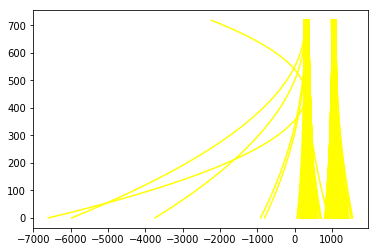

In [39]:
# process the video clip and save the result
output = 'project_output.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(24,50)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [40]:
HTML("""
<video width="1200" height="750" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
'''
# I made the left fit and right fit polys global
# need to run this cell for every run of video
left_fit = None
right_fit = None
ploty = None
'''

In [ ]:
'''
challenge_output = 'challenge_output.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(15,30)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_output_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_output_clip.write_videofile(challenge_output, audio=False)
'''